In [1]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (15, 4)})
sns.set_context('talk')

In [2]:
# Build spark session
import findspark
findspark.init('/usr/hdp/current/spark2-client')
# Build the SparkSession
from pyspark.sql import SparkSession

# Initialize Hive metastore
spark = SparkSession.builder \
    .master("local") \
    .appName("DF2HIVE") \
    .enableHiveSupport() \
    .config("spark.executor.memory", "1gb") \
    .getOrCreate()
sc = spark.sparkContext

from pyspark.sql import HiveContext
# Hive context
hc = HiveContext(sc)

# VIN type      

Select vins with type =  GE3 : A5HEV     

To get the list of GE3 VINs with more trips data points, run in hive:    
```
SELECT COUNT(day) AS counts, vin  FROM
(
SELECT a.day AS day, a.vin AS vin, b.vintype AS vintype
FROM  guobiao_tsp_tbls.trips_full_soc a
JOIN
guobiao_tsp_tbls.guobiao_vin_type b
ON (a.vin = b.vin)
WHERE b.vintype = 'A5HEV'
) c
GROUP BY vin ORDER BY counts DESC LIMIT 20;
```


Result:
counts, vin     
```
585     LMGHP1S88H1000092    
566     LMGHP1S83H1000131    
561     LMGHP1S81H1000113    
552     LMGHP1S86H1000043    
542     LMGHP1S84H1000039    
533     LMGHP1S84H1000106
524     LMGHP1S88H1000111
518     LMGHP1S88H1000030
516     LMGHP1S83H1000128
515     LMGHP1S8XH1000109
514     LMGHP1S86H1S00016
503     LMGHP1S8XH1000014
497     LMGHP1S89H1000134
474     LMGHP1S88H1S00034
431     LMGHP1S80H1S00030
388     LMGHP1S80H1S00027
225     LMGHP1S85H1000096
193     LMGHP1S54H1000161
185     LMGHP1S57H1001403
184     LMGHP1S5XH1000391
```

In [3]:
# VINs with most records
#vin = 'LMGHP1S83H1000131'
#vin = 'LMGHP1S84H1000039'
#vin = 'LMGHP1S86H1000043'
#vin = 'LMGHP1S84H1000106'
#vin = 'LMGHP1S88H1000092'
#vin = 'LMGHP1S88H1000030'
#vin = 'LMGHP1S88H1000111'
#vin = 'LMGHP1S83H1000128'
#vin = 'LMGHP1S81H1000113'
#vin = 'LMGHP1S89H1000134'
#276     LMGHP1S8XH1000014
#275     LMGHP1S8XH1000109
#256     LMGHP1S86H1S00016
#236     LMGHP1S88H1S00034
#vin = 'LMGHP1S80H1S00030'
#188     LMGHP1S80H1S00027
#178     LMGHP1S86H1S00047
#173     LMGHP1S81H1S00053
#173     LMGHP1S80H1S00061
#144     LMGHP1S85H1000096

# Patological cases
#vin = 'LMGHP1S88H1000111'
vin = 'LMGHP1S5XH1000391'
#vin = 'LMGHP1S8XH1000014'
#vin = 'LMGHP1S8XH1000109'
#vin = 'LMGHP1S59H1001127'

# Charging_full_soc table


In [4]:
table = 'guobiao_tsp_tbls.charging_full_soc'
query = 'SELECT * FROM {} WHERE vin = \'{}\''.format(table, vin)

spark_df = hc.sql("""{}""".format(query))
# Convert to pandas dataframe
df_charging = spark_df.toPandas()

# set index to end_time to make time series plots
df_charging.index = df_charging.end_time

df_charging.head(1)

,ah_throughput,battery_temp_avg,battery_temp_max,battery_temp_min,cell_volt_avg_mean,cell_volt_avg_p1,cell_volt_avg_p99,cell_volt_avg_std,cell_volt_diff_mean,cell_volt_diff_p1,...,normalized_duration,normalized_kwh_throughput,start_soc,start_time,veh_curr_mean,veh_curr_p1,veh_curr_p99,veh_curr_std,vin,day
end_time,,,,,,,,,,,,,,,,,,,,,
2018-08-27 03:22:15,103.258057,32.941576,35.0,31.0,3.823125,3.569644,4.184759,0.182395,0.015043,0.008,...,7.416021,41.109331,12.0,2018-08-26 20:59:35,-16.163117,-19.0,-14.0,1.409035,LMGHP1S5XH1000391,2018-08-27


In [5]:
table = 'guobiao_tsp_tbls.charging_v3'
query = 'SELECT * FROM {} WHERE vin = \'{}\''.format(table, vin)

spark_df = hc.sql("""{}""".format(query))
# Convert to pandas dataframe
df_charging_v3 = spark_df.toPandas()

# set index to end_time to make time series plots
df_charging_v3.index = df_charging_v3.end_time
df_charging_v3['delta_soc'] = df_charging_v3['end_soc'] - df_charging_v3['start_soc']

delta_soc_th = 40
end_soc_th = 90

df_charging_v3 = df_charging_v3.query('(delta_soc > {}) and (end_soc > {})'.format(delta_soc_th, end_soc_th)).copy()
#df_charging_v3['normalized_ah_throughput'] = df_charging_v3['capacity_throughput'] / df_charging_v3['delta_soc'] * 100 
df_charging_v3.head(1)

,ah_throughput,battery_temp_avg,battery_temp_max,battery_temp_min,cell_volt_avg_mean,cell_volt_avg_p1,cell_volt_avg_p99,cell_volt_avg_std,cell_volt_diff_mean,cell_volt_diff_p1,...,normalized_kwh_throughput,normalized_duration,start_soc,start_time,veh_curr_mean,veh_curr_p1,veh_curr_p99,veh_curr_std,vin,day
end_time,,,,,,,,,,,,,,,,,,,,,
2018-08-02 01:54:55,57.80609,31.218283,32.0,30.0,3.951458,3.719608,4.188966,0.132422,0.018537,0.016,...,7.123842,42.686658,50.0,2018-08-01 22:29:45,-16.898649,-19.5,-15.0,1.061495,LMGHP1S5XH1000391,2018-08-02


# Charging

In [6]:
table = 'guobiao_tsp_tbls.charging'
query = 'SELECT * FROM {} WHERE vin = \'{}\''.format(table, vin)

spark_df = hc.sql("""{}""".format(query))
# Convert to pandas dataframe
df_charging_all = spark_df.toPandas()

# set index to end_time to make time series plots
df_charging_all.index = df_charging_all.end_time

delta_soc_th = 40
end_soc_th = 90

df_charging_all = df_charging_all.query('(delta_soc > {}) and (end_soc > {})'.format(delta_soc_th, end_soc_th)).copy()

df_charging_all.head(1)

,ah_throughput,battery_temp_avg,battery_temp_max,battery_temp_min,cell_volt_avg_mean,cell_volt_avg_p1,cell_volt_avg_p99,cell_volt_avg_std,cell_volt_diff_mean,cell_volt_diff_p1,...,normalized_kwh_throughput,normalized_duration,start_soc,start_time,veh_curr_mean,veh_curr_p1,veh_curr_p99,veh_curr_std,vin,day
end_time,,,,,,,,,,,,,,,,,,,,,
2018-08-27 03:22:15,103.515046,32.932547,35.0,31.0,3.821733,3.564861,4.184712,0.182708,0.015037,0.008,...,7.45478,41.183034,12.0,2018-08-26 20:57:35,-16.17253,-19.0,-14.0,1.412452,LMGHP1S5XH1000391,2018-08-27


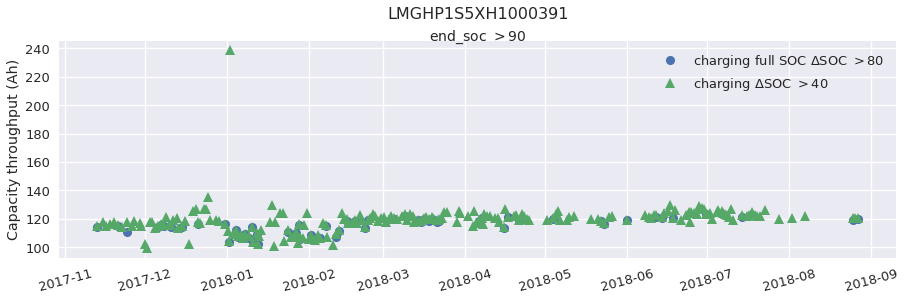

In [7]:
sns.set(rc={"figure.figsize": (15, 4)})
sns.set_context('talk')

fig, ax = plt.subplots()

ax.plot(df_charging['normalized_ah_throughput'], 'o', label='charging full SOC $\Delta$SOC $> 80$')
ax.plot(df_charging_all['normalized_ah_throughput'], '^', label='charging $\Delta$SOC $>{}$'.format(delta_soc_th))
ax.set_ylabel('Capacity throughput (Ah)')

ax.text(0.5, 1.1, '{}'.format(vin), transform=ax.transAxes, ha='center', fontsize=16)
ax.text(0.5, 1.0, 'end_soc $> 90$', transform=ax.transAxes, ha='center', fontsize=14)
ax.legend(loc=0)
plt.xticks(rotation=15)


sns.despine()

In [8]:
def get_category(x, step):
    category = (np.ceil(x / step)) * step
    return category

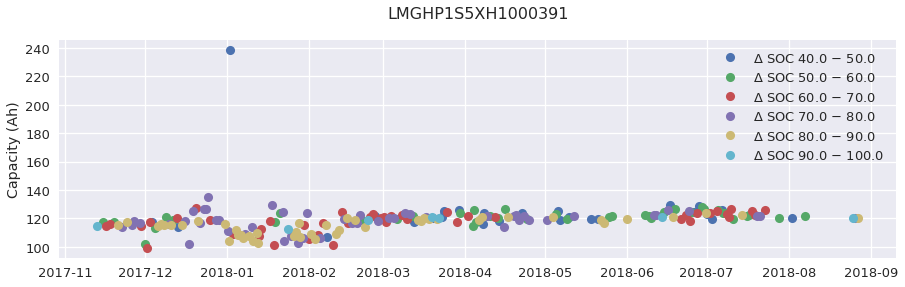

In [9]:
df = df_charging_all
    

step = 10
df['delta_soc_category'] = df['delta_soc'].apply(lambda x: get_category(x, step=step))


df.sort_index(ascending=True, inplace=True)
ts = df.reset_index(drop=True)
df['index'] = ts.index


fig, ax = plt.subplots()

col = 'normalized_ah_throughput'
cat_col = 'delta_soc_category'
categories  = list(df[cat_col].unique())
categories.sort()
ncategories = len(categories)

#palette = sns.color_palette("RdBu_r", ncategories)
#palette = sns.color_palette("cubehelix", ncategories)
palette = sns.color_palette('hls', ncategories)
sns.set_palette(palette)

for category in categories:
    df_cat = df.query('{} == {}'.format(cat_col, category))
    ax.plot(df_cat[col], 'o', label='$\Delta$ SOC {} $-$ {}'.format(category - step, category))

ax.set_ylabel('Capacity (Ah)')
ax.text(0.5, 1.1, '{}'.format(vin), transform=ax.transAxes, ha='center', fontsize=16)    
    
ax.legend(loc=0)
sns.despine()

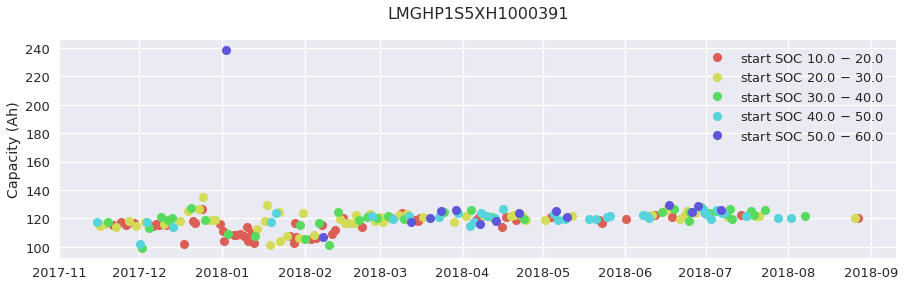

In [10]:
df = df_charging_all
    

step = 10
df['start_soc_category'] = df['start_soc'].apply(lambda x: get_category(x, step=step))


df.sort_index(ascending=True, inplace=True)
ts = df.reset_index(drop=True)
df['index'] = ts.index


fig, ax = plt.subplots()

col = 'normalized_ah_throughput'
cat_col = 'start_soc_category'
categories  = list(df[cat_col].unique())
categories.sort()
categories = categories[1:]
ncategories = len(categories)

#palette = sns.color_palette("RdBu_r", ncategories)
#palette = sns.color_palette("cubehelix", ncategories)
palette = sns.color_palette('hls', ncategories)
sns.set_palette(palette)

for category in categories:
    df_cat = df.query('{} == {}'.format(cat_col, category))
    ax.plot(df_cat[col], 'o', label='start SOC {} $-$ {}'.format(category - step, category))

ax.set_ylabel('Capacity (Ah)')
ax.text(0.5, 1.1, '{}'.format(vin), transform=ax.transAxes, ha='center', fontsize=16)    
    
ax.legend(loc=0)
sns.despine()

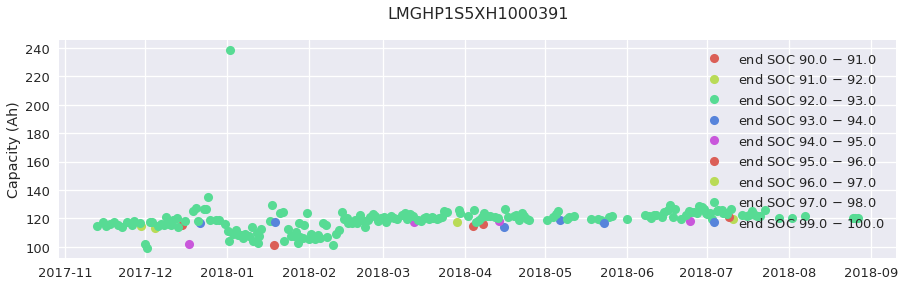

In [11]:
df = df_charging_all
    

step = 1
df['end_soc_category'] = df['end_soc'].apply(lambda x: get_category(x, step=step))


df.sort_index(ascending=True, inplace=True)
ts = df.reset_index(drop=True)
df['index'] = ts.index


fig, ax = plt.subplots()

col = 'normalized_ah_throughput'
cat_col = 'end_soc_category'
categories  = list(df[cat_col].unique())
categories.sort()
ncategories = len(categories)

#palette = sns.color_palette("RdBu_r", ncategories)
#palette = sns.color_palette("cubehelix", ncategories)
palette = sns.color_palette('hls', ncategories)
sns.set_palette(palette)

for category in categories:
    df_cat = df.query('{} == {}'.format(cat_col, category))
    ax.plot(df_cat[col], 'o', label='end SOC {} $-$ {}'.format(category - step, category))

ax.set_ylabel('Capacity (Ah)')
ax.text(0.5, 1.1, '{}'.format(vin), transform=ax.transAxes, ha='center', fontsize=16)    
    
ax.legend(loc=0)
sns.despine()

In [12]:
df.query('normalized_ah_throughput < 105')[['start_time', 'end_time']]

,start_time,end_time
end_time,,
2017-12-01 00:13:05,2017-11-30 20:27:15,2017-12-01 00:13:05
2017-12-01 19:19:55,2017-12-01 15:15:25,2017-12-01 19:19:55
2017-12-17 18:20:15,2017-12-17 13:37:35,2017-12-17 18:20:15
2018-01-01 18:50:35,2018-01-01 13:34:35,2018-01-01 18:50:35
2018-01-10 19:40:25,2018-01-10 14:11:45,2018-01-10 19:40:25
2018-01-12 17:58:45,2018-01-12 12:50:15,2018-01-12 17:58:45
2018-01-18 16:58:05,2018-01-18 12:43:35,2018-01-18 16:58:05
2018-01-22 17:13:15,2018-01-22 12:39:25,2018-01-22 17:13:15
2018-01-27 17:39:05,2018-01-27 12:50:35,2018-01-27 17:39:05


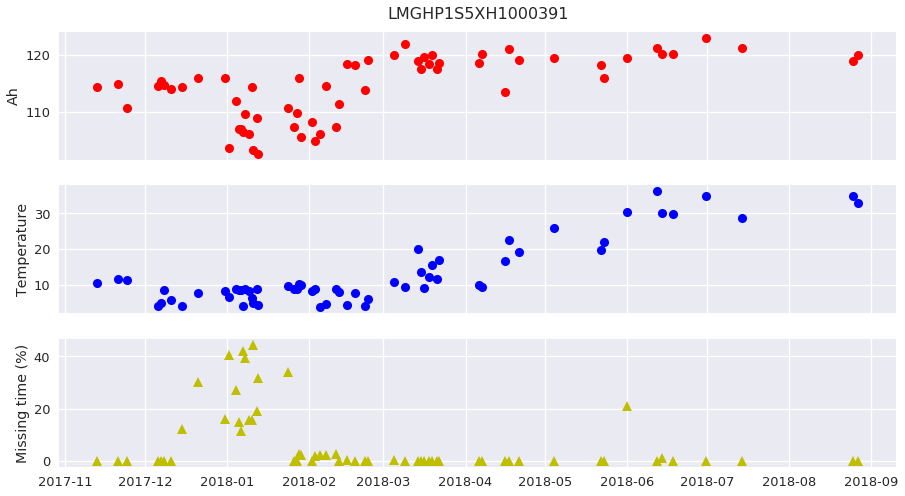

In [13]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.set_context('talk')

fig, ax = plt.subplots(3)

ax[0].plot(df_charging['normalized_ah_throughput'], 'ro', label='charging')

ax[1].plot(df_charging['battery_temp_avg'], 'bo', label='Battery temperature')

df_charging['missing_time'] = df_charging['duration'] - df_charging['count_records'] * 10 / 3600 
df_charging['missing_time'] = df_charging['missing_time'] / df_charging['duration'] * 100
ax[2].plot(df_charging['missing_time'], 'y^', label='Missing time')

ax[0].set_ylabel('Ah')
ax[1].set_ylabel('Temperature')
ax[2].set_ylabel('Missing time (%)')

ax[2].text(0.5, 1.1, '{}'.format(vin), transform=ax[0].transAxes, ha='center', fontsize=16)

plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.setp(ax[2].get_xticklabels(), rotation=0)

sns.despine()

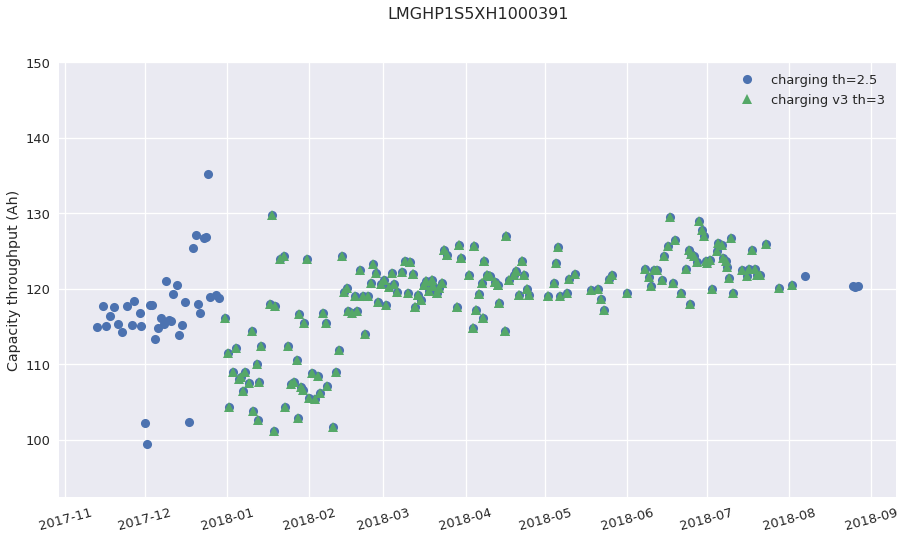

In [20]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.set_context('talk')

fig, ax = plt.subplots()

ax.plot(df_charging_all['normalized_ah_throughput'], 'o', label='charging th=2.5')
ax.plot(df_charging_v3['normalized_ah_throughput'], '^', label='charging v3 th=3')
ax.set_ylabel('Capacity throughput (Ah)')
ax.set_ylim(top=150)
ax.text(0.5, 1.1, '{}'.format(vin), transform=ax.transAxes, ha='center', fontsize=16)
#ax.text(0.5, 1.0, 'end_soc $> 90$', transform=ax.transAxes, ha='center', fontsize=14)
ax.legend(loc=0)
plt.xticks(rotation=15)


sns.despine()

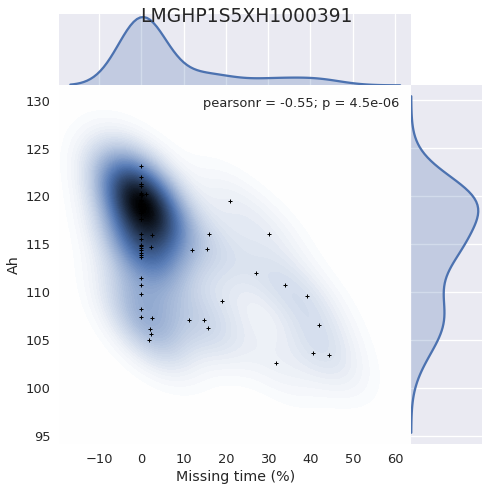

In [15]:
g = sns.jointplot(x='missing_time', y='normalized_ah_throughput', data=df_charging, kind="kde", ratio=5, size=7, space=0, n_levels=100)
g.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+" )
g.set_axis_labels('Missing time (%)', 'Ah')
g.fig.suptitle(vin)
sns.despine()

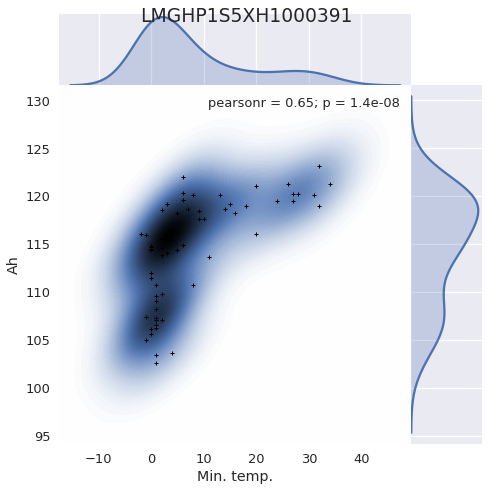

In [16]:
g = sns.jointplot(x='battery_temp_min', y='normalized_ah_throughput', data=df_charging, kind="kde", ratio=5, size=7, space=0, n_levels=100)
g.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+" )
g.set_axis_labels('Min. temp.', 'Ah')
g.fig.suptitle(vin)
sns.despine()

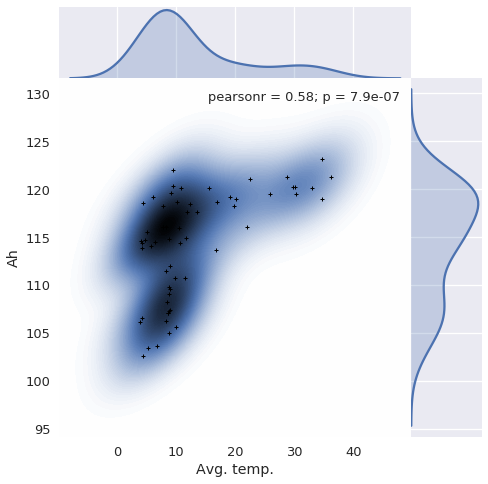

In [17]:
g = sns.jointplot(x='battery_temp_avg', y='normalized_ah_throughput', data=df_charging, kind="kde", ratio=5, size=7, space=0, n_levels=100)
g.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+" )
g.set_axis_labels('Avg. temp.', 'Ah')
sns.despine()